## What we expect to see
I don't want to manually define the value of each index of $p[i]$ and $c[i,j,k]$ in `eqs` every time. That would require me to know the size of $Np$ and $Nc$ in advance, and hardcode the `eqs` accordingly. Instead, here is a vectorized version. To check whether the reported equations are correct, I have also created some diagrams to help keep track of the terms.

![alt text](https://github.com/acossairt/traffic_air_quality_modeling/blob/main/images/julia_notation_diagram_1.png?raw=true)
![alt text](https://github.com/acossairt/traffic_air_quality_modeling/blob/main/images/julia_notation_diagram_2.png?raw=true)

## Equations we would expect
This final diagram shows the equation would expect for $\frac{dp(t)_1}{dt}$ (sum along the green columns, subtract the sum along the yellow rows).
![alt text](https://github.com/acossairt/traffic_air_quality_modeling/blob/main/images/julia_notation_diagram_3.png?raw=true)

In [43]:
using ModelingToolkit, DifferentialEquations, Plots, LinearAlgebra
using ModelingToolkit: t_nounits as t, D_nounits as D

#First build the symbolic model

#Set the number of patches
Np=2
#Set the number of corridors
Nc=2

#patches
@variables p(t)[1:Np]
#corridors
@variables c(t)[1:Np,1:Np,1:Nc] # notice that we must specify the number of corridors (layers) in the *last* index

@parameters α[1:Np]
@parameters β[1:Nc]
@parameters d[1:Np]

#define the corridor flux matrices
#notice the use of `.` notation before each arithmetic operation, but NOT before `=`

EnFlx(p,c,d,α,β) = exp.(-α .* β .* c) .* p .* d
ExFlx(c,β) = exp.(-β.*c).*c

#define equations
#notice there are only two equations, regardless of the size of Np or Nc

eqs = [
    D.(p) ~ [sum(ExFlx(c,β[1])[:,i,:]) for i in 1:Np] .- [sum(EnFlx(p,c,d,α[1],β[1])[i,:,:]) for i in 1:Np],
    D.(c) ~ collect(-ExFlx(c,β[1]) + EnFlx(p,c,d,α[1],β[1])),
]
#=
  Notice we only used "collect()" in the equation for D.(c). 
  For D.(p), we summed over the columns of the EnFlx matrix and over the columns of the ExFlx matrix, 
  then took their difference. If you don't do this (summing), you will get an error because you will be 
  attempting to save an object of shape (2,2,1) into an object of shape (2,).
=#

#build model symbolically
@mtkbuild model = ODESystem(eqs, t)


Model model with 10 equations
Unknowns (10):
  (p(t))[1]
  (p(t))[2]
  (c(t))[1, 1, 1]
  (c(t))[2, 1, 1]
  (c(t))[1, 2, 1]
  (c(t))[2, 2, 1]
⋮
Parameters (3):
  β[1]
  α[1]
  d

## Fast pipeline (call from helper functions)
Let's see if we can do all of this faster, in a more streamlined way.

In [108]:
include("/Users/auroracossairt/opt/traffic_air_quality_modeling/julia_model/help_funcs.jl")
using .HelpFuncs
using ModelingToolkit, DifferentialEquations, Plots, LinearAlgebra

2×2×2 Array{Float64, 3}:
[:, :, 1] =
  1.0  15.0
 15.0   1.0

[:, :, 2] =
  1.0  40.0
 40.0   1.0

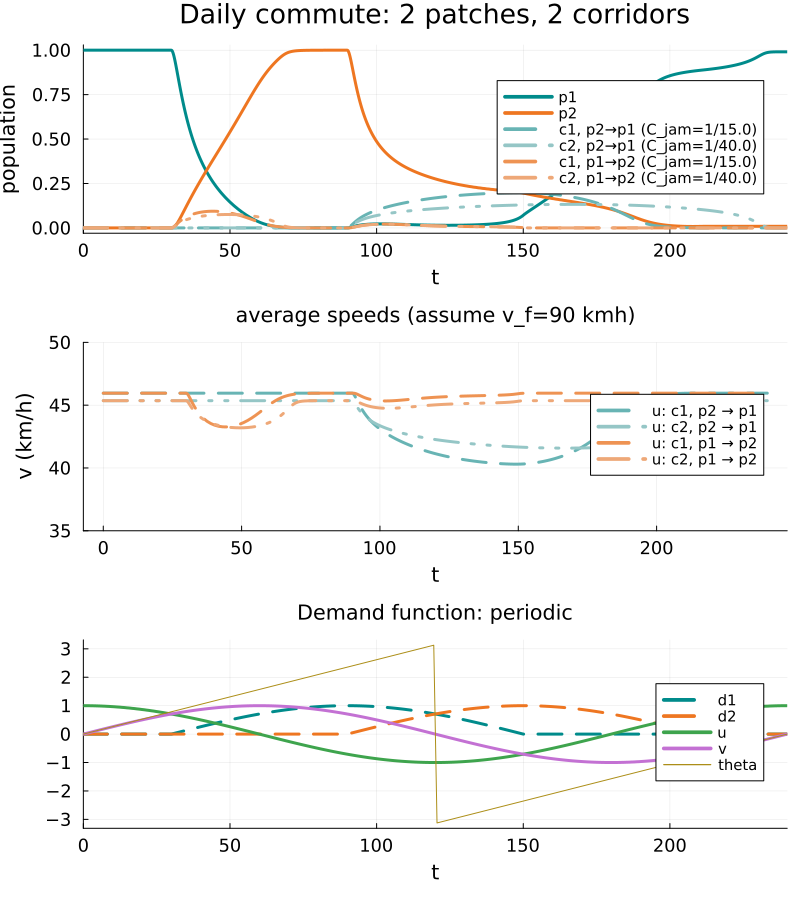

In [109]:
## Practice and play!
Np = 2
Nc = 2
# Set initial conditions
pm = [1.0; 0.0]
cm = zeros(2,2,Nc)
cm[1,2,1] = 0.00
cm[2,1,1] = 0.00
my_u = 1
my_v = 0

# Set parameters
my_α = [1]     # Tolerance for congestion (assume same for patch 1 and patch 2)
my_β = ones(2,2,Nc)    # Inverse road capacity (for now, assume same for all corridors)
my_β[1,2,1] = 15
my_β[1,2,2] = 40
my_β[2,1,1] = 15
my_β[2,1,2] = 40
display(my_β)
my_d = [1; 0]  # Fraction of population desiring to leave patch i
my_t_end = 240
my_period = 240 # Do these have to always be the same?
demand_function = "step"

model, prob, plt = HelpFuncs.build_symbolic_model_diurnal(Np=2, Nc=Nc, pm=pm, cm=cm, my_u=my_u, my_v=my_v, my_α=my_α, my_β=my_β, d_version = demand_function, my_period = my_period, t_end = my_t_end)
savefig(plt,"traffic_pop_curve_diurnal_test_" * demand_function * "_Nc_$Nc.png")
display(plt)

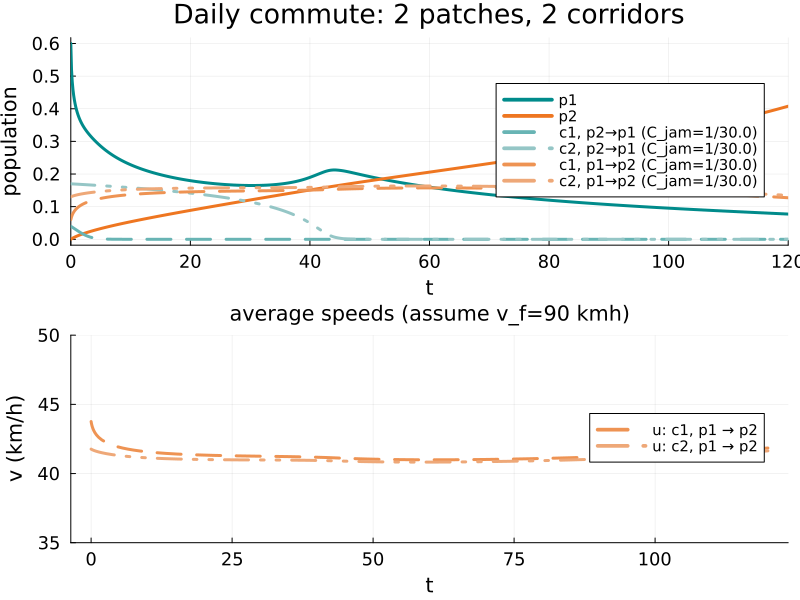

"/Users/auroracossairt/opt/traffic_air_quality_modeling/experiments_and_tutorials/traffic_pop_curve_test.png"

In [81]:
# Set initial conditions
pm = [0.6; 0.0]
cm = zeros(2,2,2)
cm[1,2,1] = 0.06
cm[2,1,1] = 0.04
cm[1,2,2] = 0.13
cm[2,1,2] = 0.17

# Set parameters
my_α = [1]     # Tolerance for congestion (assume same for patch 1 and patch 2)
my_β = 30*ones(2,2,2)    # Inverse road capacity (for now, assume same for all corridors)
my_d = [1; 0]  # Fraction of population desiring to leave patch i

model, prob, plt = HelpFuncs.build_symbolic_model(Np=2, Nc=2, pm=pm, cm=cm, my_α=my_α, my_β=my_β, my_d=my_d)
display(plt)
savefig(plt,"traffic_pop_curve_test.png")

## Quick restart

In [82]:
include("/Users/auroracossairt/opt/traffic_air_quality_modeling/julia_model/help_funcs.jl")
using .HelpFuncs
using ModelingToolkit, DifferentialEquations, Plots, LinearAlgebra

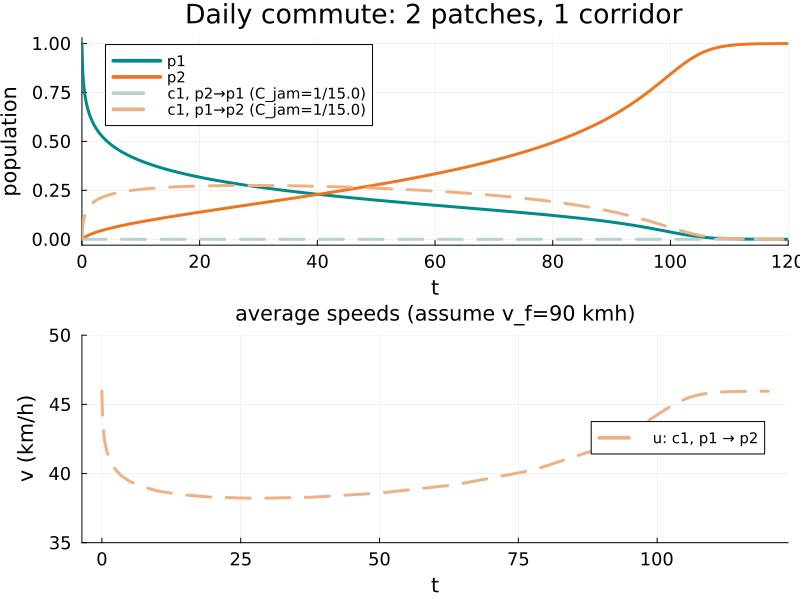

In [83]:
## Practice and play!
Np = 2
Nc = 1
# Set initial conditions
pm = [1.0; 0.0]
cm = zeros(2,2,Nc)
cm[1,2,1] = 0.00
cm[2,1,1] = 0.00

# Set parameters
my_α = [1]     # Tolerance for congestion (assume same for patch 1 and patch 2)
my_β = 15*ones(2,2,Nc)    # Inverse road capacity (for now, assume same for all corridors)
my_d = [1; 0]  # Fraction of population desiring to leave patch i

model, prob, plt = HelpFuncs.build_symbolic_model(Np=2, Nc=Nc, pm=pm, cm=cm, my_α=my_α, my_β=my_β, my_d=my_d)
savefig(plt,"traffic_pop_curve_test_Nc_$Nc.png")
display(plt)

## Playing with diurnal demand pattern

In [15]:
include("/Users/auroracossairt/opt/traffic_air_quality_modeling/julia_model/help_funcs.jl")
using .HelpFuncs
using ModelingToolkit, DifferentialEquations, Plots, LinearAlgebra

Real[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


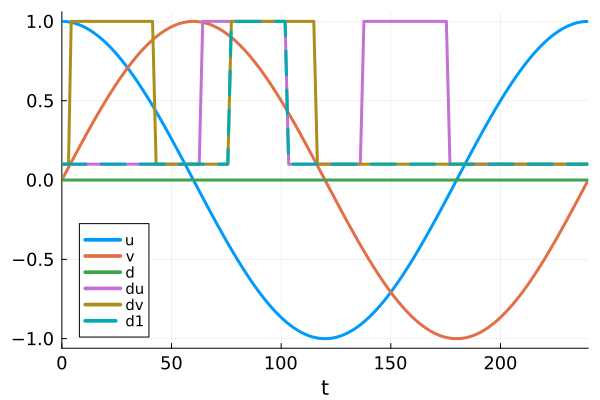

In [14]:
## Practice and play!
Np = 2
Nc = 2
# Set initial conditions
my_u = 1
my_v = 0

# Set parameters
my_t_end = 240
my_period = 240 # Do these have to always be the same?

# Model, solve, and plot
model, prob, plt = HelpFuncs.build_diurnal_model(my_u=my_u, my_v=my_v, my_period = my_period, t_end = my_t_end)
display(plt)